# Описание модели

## Q-learning with QRE-based exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib. pyplot as plt
from config import *

from game import StaticGame
from agents import QREAgent

In [35]:
plots = [('seller', 'lemon'), ('seller', 'peach'), 
         ('buyer', 'low_price'), ('buyer', 'high_price')]
actions = {
    'seller': ['high price', 'low price'],
    'buyer': ['buy', 'do not buy'],
}

def plot_results(data, title, n_iters=n_iters):
    # data is either qvalues or probs
    f, axarr = plt.subplots(2, 2, figsize=(10, 10))

    for idx, (player, obs) in enumerate(plots):
        axarr[idx // 2, idx % 2].plot(range(n_iters), 
                                      np.array(data[player][obs])[:, 0], 
                                      label=actions[player][0])
        axarr[idx // 2, idx % 2].plot(range(n_iters), 
                                      np.array(data[player][obs])[:, 1], 
                                      label=actions[player][1])
        axarr[idx // 2, idx % 2].legend(fontsize=12)
        axarr[idx // 2, idx % 2].set_title(title + ': ' + player + ' ' + obs, fontsize=12)

In [73]:
def plot_trust_honesty(stats, rolling_num=20):
    trust = pd.Series((stats[:, 2] == 0).astype(int)).rolling(rolling_num).mean()
    honesty = pd.Series(np.logical_xor(stats[:, 0], stats[:, 1]).astype(int)).rolling(rolling_num).mean()
    lemon_honesty = (
        pd.Series(np.logical_and((stats[:, 0] == 0), (stats[:, 1] == 1))).rolling(rolling_num).sum() / 
        pd.Series((stats[:, 0] == 0).astype(int)).rolling(rolling_num).sum()
    )
    
    f, axarr = plt.subplots(2, 1, figsize=(12, 8))
    axarr[0].plot(range(n_iters), trust, color='blue')
    axarr[0].set_title('trust', fontsize=14)
    axarr[0].grid()

    axarr[1].plot(range(n_iters), honesty, color='green')
    axarr[1].set_title('honesty', fontsize=14)
    axarr[1].grid()
    
    print('% заключенных сделок:', np.sum(stats[:, 2] == 0) / len(stats))
    
    return trust, honesty, lemon_honesty

In [28]:
def play_game(qval_init_buyer, 
              qval_init_seller, 
              seller_lambda_init, 
              buyer_lambda_init, 
              seller_lr, 
              buyer_lr, n_iters):
    agent_seller = QREAgent(name='seller', player_lambda=seller_lambda_init, qval=qval_init_seller, lr=seller_lr)
    agent_buyer = QREAgent(name='buyer', player_lambda=buyer_lambda_init, qval=qval_init_buyer, lr=buyer_lr)
    
    game = StaticGame()
    
    # game history
    prev_seller, prev_buyer = dict(), dict()
    is_prev = False
    total_rewards = {'seller': [], 'buyer': []}
    qvalues = {
        'seller': {'lemon': [], 'peach': []}, 
        'buyer': {'high_price': [], 'low_price': []},
    }
    probs = {
        'seller': {'lemon': [], 'peach': []}, 
        'buyer': {'high_price': [], 'low_price': []},
    }
    stats = np.zeros((n_iters, 3))

    for step in range(n_iters):
        game.reset()

        seller_action = agent_seller.choose_action(game.car_type)
        game.step('seller', seller_action)
        buyer_action = agent_buyer.choose_action(seller_action)
        game.step('buyer', buyer_action)
        print('Step #', '\t', step, '\t', game.car_type, '\t', 
              seller_action, '\t', buyer_action)

        if is_prev:
            agent_seller.update(prev_seller['obs'], prev_seller['action'], 
                                game.car_type, prev_seller['reward'])
            agent_buyer.update(prev_buyer['obs'], prev_buyer['action'], 
                               seller_action, prev_buyer['reward'])

        prev_seller.update({
            'obs': game.car_type,
            'action': seller_action,
            'reward': game.reward('seller'),
        })
    
        prev_buyer.update({
            'obs': seller_action,
            'action': buyer_action,
            'reward': game.reward('buyer'),
        })
        is_prev = True

        # total rewards
        total_rewards['seller'].append(game.reward('seller'))
        total_rewards['buyer'].append(game.reward('buyer'))
    
        # history q_values
        for obs_type in ('lemon', 'peach'):
            qvalues['seller'][obs_type].append(list(agent_seller.qval[obs_type]))
            probs['seller'][obs_type].append(list(agent_seller.probs[obs_type]))
        for obs_type in ('high_price', 'low_price'):
            qvalues['buyer'][obs_type].append(list(agent_buyer.qval[obs_type]))
            probs['buyer'][obs_type].append(list(agent_buyer.probs[obs_type]))
    
        # stats for honesty and trust computing
        stats[step, 0] = CAR_TYPE_TO_ID[game.car_type]
        stats[step, 1] = ACTION_TO_ID['seller'][seller_action]
        stats[step, 2] = ACTION_TO_ID['buyer'][buyer_action]
    return qvalues, probs, stats, total_rewards

In [69]:
# parameters

# fully trusting
qval_init_buyer = {
    'high_price': [1, 0],
    'low_price': [1, 0],
}

# fully fair
qval_init_seller = {
    'lemon': [0, 1],
    'peach': [1, 0],
}

seller_lambda_init = 0.5
buyer_lambda_init = 0.5

seller_lr = 0.1

buyer_lr = 0.1

n_iters = 500

# lemon-peach, high_price-low_price, buy-not_buy

In [70]:
qvalues, probs, stats, total_rewards = play_game(qval_init_buyer, 
                                                 qval_init_seller, 
                                                 seller_lambda_init, 
                                                 buyer_lambda_init, 
                                                 seller_lr, 
                                                 buyer_lr, 
                                                 n_iters)

Step # 	 0 	 lemon 	 low_price 	 buy
Step # 	 1 	 peach 	 high_price 	 buy
Step # 	 2 	 peach 	 high_price 	 buy
Step # 	 3 	 peach 	 low_price 	 not_buy
Step # 	 4 	 peach 	 low_price 	 buy
Step # 	 5 	 peach 	 high_price 	 buy
Step # 	 6 	 peach 	 high_price 	 buy
Step # 	 7 	 peach 	 high_price 	 buy
Step # 	 8 	 peach 	 high_price 	 not_buy
Step # 	 9 	 peach 	 high_price 	 buy
Step # 	 10 	 peach 	 high_price 	 buy
Step # 	 11 	 peach 	 high_price 	 not_buy
Step # 	 12 	 peach 	 high_price 	 not_buy
Step # 	 13 	 peach 	 high_price 	 buy
Step # 	 14 	 lemon 	 low_price 	 not_buy
Step # 	 15 	 lemon 	 low_price 	 buy
Step # 	 16 	 peach 	 low_price 	 buy
Step # 	 17 	 lemon 	 low_price 	 not_buy
Step # 	 18 	 peach 	 high_price 	 buy
Step # 	 19 	 peach 	 low_price 	 buy
Step # 	 20 	 peach 	 low_price 	 not_buy
Step # 	 21 	 lemon 	 high_price 	 buy
Step # 	 22 	 lemon 	 high_price 	 not_buy
Step # 	 23 	 lemon 	 low_price 	 buy
Step # 	 24 	 peach 	 low_price 	 buy
Step # 	 25 	 

Step # 	 300 	 peach 	 high_price 	 buy
Step # 	 301 	 lemon 	 high_price 	 not_buy
Step # 	 302 	 peach 	 high_price 	 not_buy
Step # 	 303 	 lemon 	 high_price 	 not_buy
Step # 	 304 	 peach 	 high_price 	 not_buy
Step # 	 305 	 peach 	 high_price 	 not_buy
Step # 	 306 	 peach 	 high_price 	 not_buy
Step # 	 307 	 peach 	 high_price 	 buy
Step # 	 308 	 lemon 	 high_price 	 not_buy
Step # 	 309 	 peach 	 high_price 	 not_buy
Step # 	 310 	 peach 	 high_price 	 not_buy
Step # 	 311 	 peach 	 high_price 	 buy
Step # 	 312 	 peach 	 high_price 	 not_buy
Step # 	 313 	 peach 	 high_price 	 not_buy
Step # 	 314 	 peach 	 high_price 	 not_buy
Step # 	 315 	 peach 	 high_price 	 buy
Step # 	 316 	 peach 	 high_price 	 not_buy
Step # 	 317 	 peach 	 high_price 	 not_buy
Step # 	 318 	 peach 	 high_price 	 buy
Step # 	 319 	 peach 	 high_price 	 not_buy
Step # 	 320 	 lemon 	 high_price 	 not_buy
Step # 	 321 	 peach 	 high_price 	 not_buy
Step # 	 322 	 peach 	 high_price 	 not_buy
Step # 	

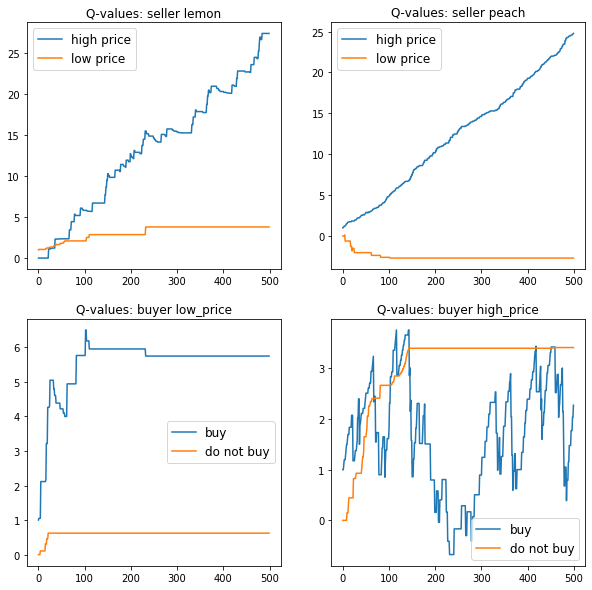

In [71]:
plot_results(qvalues, 'Q-values', n_iters=n_iters)

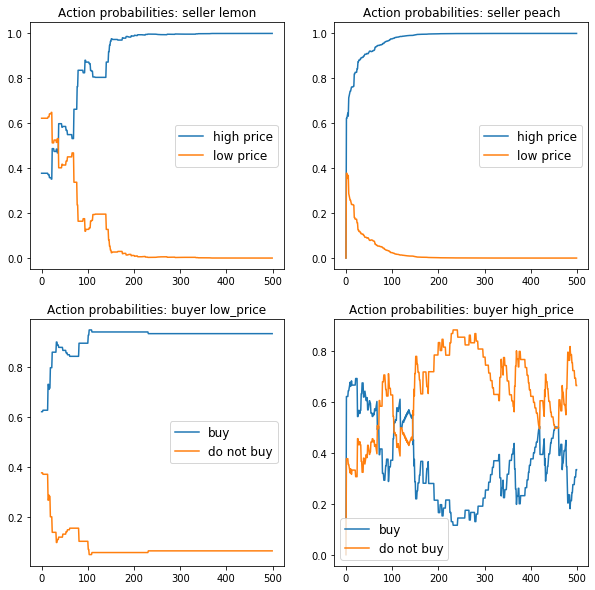

In [72]:
plot_results(probs, 'Action probabilities', n_iters=n_iters)

% заключенных сделок: 0.376


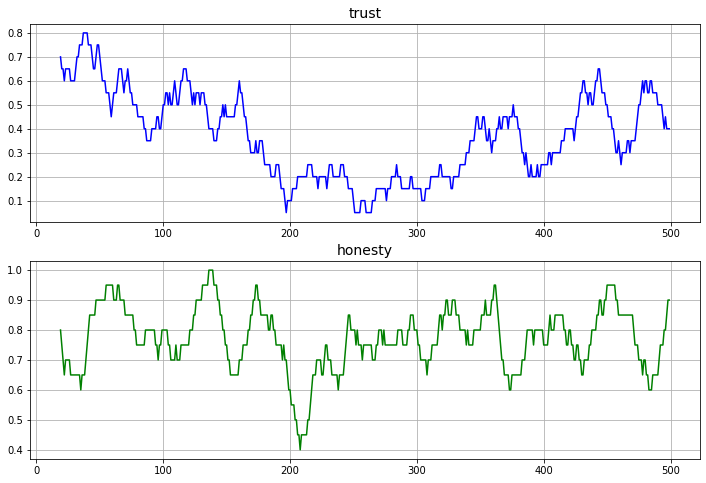

In [76]:
_ = plot_trust_honesty(stats)

Закономерность между параметрами?

Пример использования игры и агента.

In [1]:
import numpy as np
import pandas as pd

In [2]:
from game import StaticGame

In [3]:
game_example = StaticGame()
game_example.reset()
game_example.player_choices

{'seller': None, 'buyer': None}

In [4]:
from agents import QREAgent

In [7]:
agent = QREAgent(name='seller', player_lambda=1.)

In [10]:
agent.current_probs

array([0., 0.])

In [11]:
agent.choose_action('lemon')

'low_price'

In [12]:
agent.update('peach', 'high_price', 'lemon', 1.)

In [13]:
agent.qval

defaultdict(<function agents.QREAgent.<lambda>()>,
            {'lemon': array([0., 0.]), 'peach': array([0.01, 0.  ])})